In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16_bn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import torchvision.transforms.v2.functional as TF
from sklearn.model_selection import train_test_split, KFold
from torchmetrics.functional import dice
import cv2
import pandas as pd

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm import tqdm
import random
import PIL

from utils.early_stopping import EarlyStopping

/cs/student/projects1/2021/izaffar/miniconda3/envs/fyp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.hub.set_dir('/cs/student/projects1/2021/izaffar/.cache/torch/hub')

In [3]:
DATA_DIR = "../data"
for filename in os.listdir(DATA_DIR):
    print(filename)

images_best_slice
images_slices
info.csv
masks_both
masks_right
mul_mm.png
masks_area
masks_both_w2
masks_both_w3
masks_right_w2
masks_right_w3
bob.py
dicom_reader.ipynb


In [4]:
# Use GPU
# device = "mps" if torch.backends.mps.is_available() else "cpu"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [5]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, indices, model_name, mask_type, transform=False, device="cpu"):
        self.data_dir = data_dir
        self.model_name = model_name
        self.transform = transform
        self.device = device

        self.csv_path = os.path.join(data_dir, "info.csv")
        self.data_df = pd.read_csv(self.csv_path)
        self.data_df = self.data_df.iloc[indices]

        # image dir
        self.image_dir = os.path.join(data_dir, "images_best_slice")
        self.image_files = np.array(sorted(os.listdir(self.image_dir)))[indices]

        # mask dir
        self.mask_dir = os.path.join(data_dir, f"masks_{mask_type}")
        self.mask_files = np.array(sorted(os.listdir(self.mask_dir)))[indices]

        assert len(self.image_files) == len(self.mask_files)

    def slice_transform(self, slice_image):
        if self.model_name == "brain_mri":
            m, s = np.mean(slice_image, axis=(0, 1)), np.std(slice_image, axis=(0, 1))
            preprocess = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.CenterCrop((256, 256)),
                    transforms.Normalize(mean=m, std=s),
                    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]
            )
            input_tensor = preprocess(slice_image)
        else:
            # stack image 3 channels rgb
            # slice_image = np.stack((slice_image,) * 3, axis=-1)
            preprocess = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.CenterCrop((320, 320)),
                    # transforms.Normalize(mean=m, std=s),
                ]
            )
            input_tensor = preprocess(get_preprocessing_fn(self.model_name)(slice_image))
        return input_tensor

    def mask_transform(self, mask_image):
        if self.model_name == "brain_mri":
            preprocess = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.CenterCrop((256, 256)),
                ]
            )
            mask_image = preprocess(mask_image)
        else:
            preprocess = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.CenterCrop((320, 320)),
                ]
            )
            mask_image = preprocess(mask_image)
        return mask_image

    def data_aug_transform(self, image, mask):
        # Random horizontal flipping
        if random.random() > 0.5:
            # print("hflip")
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Random vertical flipping
        if random.random() > 0.5:
            # print("vflip")
            image = TF.vflip(image)
            mask = TF.vflip(mask)
        
        # Random rotation
        # if random.random() > 0.5:
        #     # print("rotate")
        #     angle = random.randint(-30, 30)
        #     image = TF.rotate(image, angle)
        #     mask = TF.rotate(mask, angle)
        
        # Random zoom in
        if random.random() > 0.5:
            # print("zoom")
            scale = random.uniform(0.9, 1.1)
            image = TF.resized_crop(image, 0, 0, int(320*scale), int(320*scale), (320, 320))
            mask = TF.resized_crop(mask, 0, 0, int(320*scale), int(320*scale), (320, 320))
        
        return image, mask

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        mul = self.data_df["mul_mm"].values[idx]
        # patient_id_df = self.data_df["patient_id"].values[idx]
        # patient_id_img = self.image_files[idx]
        # print(patient_id_df, patient_id_img)
        
        # Load image and mask
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        # image = np.load(image_path).astype(np.float32)
        # mask = np.load(mask_path).astype(np.float32)
        image = PIL.Image.fromarray(np.load(image_path).astype(np.float32))
        mask = PIL.Image.fromarray(np.load(mask_path).astype(np.float32))

        # data augmentation
        if self.transform:
            image, mask = self.data_aug_transform(image, mask)

        if self.model_name == "brain_mri":
            image = self.slice_transform(image).to(self.device)
            mask = self.mask_transform(mask).to(self.device)
        else:
            # processing_fn = get_preprocessing_fn(self.model_name)
            
            # image = np.stack((image,) * 3, axis=-1) # stack image 3 channels rgb
            # image = processing_fn(np.array(image))
        
            standard_transform = transforms.Compose(
                [
                    transforms.v2.CenterCrop((320, 320)),
                    transforms.v2.ToImage(),
                    transforms.v2.ToDtype(torch.float32, scale=True)
                ]
            )
            image = standard_transform(image).to(self.device)
            mask = standard_transform(mask).to(self.device)
        
        return image, mask, mul


In [6]:
def get_brain_mri_model():
    pretrained_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        in_channels=3, out_channels=1, init_features=32, pretrained=True)
    # pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
    # pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

    new_in_channels = 1
    modified_encoder1_weight = pretrained_model.encoder1.enc1conv1.weight.data[:, :new_in_channels, :, :]
    pretrained_model.encoder1.enc1conv1 = nn.Conv2d(new_in_channels, 32, kernel_size=3, padding=1)

    # Modify the output channels
    new_out_channels = 1
    modified_conv_weight = pretrained_model.conv.weight.data[:new_out_channels, :, :, :]
    modified_conv_bias = pretrained_model.conv.bias.data[:new_out_channels]
    pretrained_model.conv = nn.Conv2d(32, new_out_channels, kernel_size=1)

    # Assign the modified weights
    pretrained_model.encoder1.enc1conv1.weight.data = modified_encoder1_weight
    pretrained_model.conv.weight.data = modified_conv_weight
    pretrained_model.conv.bias.data = modified_conv_bias
    return pretrained_model

def get_model(model_arch, model_backbone, device="cpu"):
    if model_arch == "UNet" and model_backbone == "brain_mri":
        return get_brain_mri_model().to(device)
    elif model_arch == "UNet":
        return smp.Unet(
            encoder_name=model_backbone,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=1,                      # model output channels (number of classes in your dataset)
            activation="sigmoid",
        ).to(device)
    elif model_arch == "UNet++":
        return smp.UnetPlusPlus(
            encoder_name=model_backbone,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=1,                      # model output channels (number of classes in your dataset)
            activation="sigmoid",
        ).to(device)
    elif model_arch == "FPN":
        return smp.FPN(
            encoder_name=model_backbone,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=1,                      # model output channels (number of classes in your dataset)
            activation="sigmoid",
        ).to(device)
    elif model_arch == "DeepLabV3+":
        return smp.DeepLabV3Plus(
            encoder_name=model_backbone,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=1,                      # model output channels (number of classes in your dataset)
            activation="sigmoid",
        ).to(device)

In [7]:
class CombinedLoss(nn.Module):
    def __init__(self, adaptive=False, alpha=1.0, threshold_epochs=10, threshold_length_loss=100.0):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.adaptive = adaptive
        self.threshold_epochs = threshold_epochs
        self.threshold_length_loss = threshold_length_loss
        self.mask_loss_fn = nn.BCELoss()
        self.length_loss_fn = nn.MSELoss()

    def forward(self, pred, pred_lengths, targets, target_lengths, epoch):
        mask_loss = self.mask_loss_fn(pred, targets)
        length_loss = self.length_loss_fn(pred_lengths, target_lengths)
        # length_loss /= 1000.0 # Scale the length loss to be in the same range as the mask loss

        print(mask_loss, length_loss)
        # print(mask_loss.grad_fn, length_loss.grad_fn)

        if not self.adaptive:
            # combined_loss = mask_loss
            combined_loss = mask_loss + self.alpha * length_loss / 1000.0
        else:
            # Combine both losses
            if epoch > self.threshold_epochs and length_loss < self.threshold_length_loss:
                combined_loss = mask_loss + self.alpha * length_loss / 1000.0
            else:
                combined_loss = mask_loss
        return combined_loss

def convert_pixels_to_mm(length_pixels, resized_image_width_pixels=320, required_image_width_pixels=320, scale_factor=0.56525):
    # image_width_pixels = image.size(2)
    length_mm = length_pixels * (required_image_width_pixels / resized_image_width_pixels) * scale_factor
    return length_mm

def get_length_line_simple(masks):
    batch_size, _, image_width, image_height = masks.size()
    masks = masks.squeeze(1)
    lengths = []

    for i in range(batch_size):
        mask = masks[i]  # Select the mask for the current sample
        
        # Find indices of non-zero elements (where the mask is 1)
        nonzero_indices = torch.nonzero(mask, as_tuple=False)
        
        if len(nonzero_indices) > 0:
            # Compute the bounding rectangle from the non-zero indices
            x, y, w, h = cv2.boundingRect(nonzero_indices.cpu().numpy())
            
            # Calculate the diagonal length of the bounding rectangle
            diagonal_length = torch.sqrt(torch.tensor(w**2 + h**2, dtype=torch.float32))
            diagonal_length_mm = convert_pixels_to_mm(diagonal_length)
            lengths.append(diagonal_length_mm)
            
            # # Compute the bounding box from the non-zero indices
            # min_x = nonzero_indices[:, 1].min().item()
            # min_y = nonzero_indices[:, 0].min().item()
            # max_x = nonzero_indices[:, 1].max().item()
            # max_y = nonzero_indices[:, 0].max().item()

            # # Calculate the diagonal length of the bounding box
            # width = max_x - min_x
            # height = max_y - min_y
            # diagonal_length = torch.sqrt(torch.tensor(width**2 + height**2, dtype=torch.float32))
            # diagonal_length_mm = convert_pixels_to_mm(diagonal_length, image_width)
            # lengths.append(diagonal_length_mm)
        else:
            lengths.append(torch.tensor(0.0))  # If no non-zero elements found, return length 0

    return torch.stack(lengths)

def get_length_line(masks):
    batch_size, _, image_width, image_height = masks.size()
    masks = masks.squeeze(1)
    lengths = []

    for i in range(batch_size):
        mask_np = masks[i].cpu().numpy()
        mask_np = mask_np.astype(np.uint8) * 255

        # Apply skeletonization to thin the line
        # skeleton = cv2.ximgproc.thinning(mask.astype(np.uint8) * 255)

        # Find contours on the skeleton
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # print(contours)

        # Initialize total length
        total_length = torch.tensor(0.0)

        # Iterate through each contour
        for contour in contours:
            # Compute the length of each contour using PyTorch operations
            length_tensor = torch.tensor(
                cv2.arcLength(contour, closed=True), dtype=torch.float32
            )
            total_length += length_tensor

        total_length_mm = convert_pixels_to_mm(total_length, image_width)
        lengths.append(total_length_mm)
        # print("Total length of the line:", total_length)

    return torch.stack(lengths)

def thin_line_skeleton(mask, show_plot=False):
    # Convert the torch tensor to a NumPy array
    mask_np = mask.cpu().numpy() if mask.is_cuda else mask.numpy()

    # Convert the mask to uint8 for OpenCV operations
    mask_np = mask_np.squeeze().astype(np.uint8)
    # print(mask_np.shape)
    # print(mask_np.dtype)
    # print(mask_np.min(), mask_np.max())
    
    # Apply skeletonization to thin the line
    mask_skeleton_np_gh = cv2.ximgproc.thinning(mask_np * 255, thinningType=cv2.ximgproc.THINNING_GUOHALL)
    mask_skeleton_np_zs = cv2.ximgproc.thinning(mask_np * 255, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
    
    if show_plot:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].set_title("Original Mask")
        axs[0].imshow(mask_np, cmap="gray", alpha=1.0)
        axs[1].set_title("Guo-Hall Thinning")
        axs[1].imshow(mask_skeleton_np_gh, cmap="gray", alpha=1.0)
        axs[2].set_title("Zhang-Suen Thinning")
        axs[2].imshow(mask_skeleton_np_zs, cmap="gray", alpha=1.0)
        plt.show()
    
    # Convert the result back to a torch tensor
    mask_skeleton = torch.tensor(mask_skeleton_np_gh / 255, dtype=mask.dtype)
    
    return mask_skeleton

def remove_small_noise(mask, kernel_size):
    # Convert the torch tensor to a NumPy array
    mask_np = mask.cpu().numpy() if mask.is_cuda else mask.numpy()
    
    # Convert the mask to uint8 for OpenCV operations
    mask_np = (mask_np * 255).astype(np.uint8)
    
    # Create a kernel for morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    
    # Perform morphological opening
    mask_clean_np = cv2.morphologyEx(mask_np, cv2.MORPH_OPEN, kernel)
    
    # Convert the result back to a torch tensor
    mask_clean = torch.tensor(mask_clean_np / 255, dtype=mask.dtype)
    
    return mask_clean

### Visualisations for Report

In [8]:
"""image_dir = os.path.join(DATA_DIR, "images_best_slice")
data_count = len(os.listdir(image_dir))
# print(data_count)

# Split the data into temporary and test data
train_val_indices, test_indices = train_test_split(
    list(range(data_count)), test_size=(20/100), random_state=42
)

# Split the temporary data into training and validation
train_indices, val_indices = train_test_split(
    train_val_indices, test_size=(20/(100-20)), random_state=42
)

idx = val_indices[3]

mask_dir = os.path.join(DATA_DIR, "masks_right_w3")
mask_path = os.path.join(mask_dir, os.listdir(mask_dir)[idx])
mask = np.load(mask_path)
# skel = cv2.ximgproc.thinning(mask.astype(np.uint8) * 255, thinningType=cv2.ximgproc.THINNING_GUOHALL)
# plt.imshow(mask, cmap="gray")
# plt.show()
# plt.imshow(skel, cmap="gray")
# plt.show()

skel = thin_line_skeleton(torch.tensor(mask).unsqueeze(1), show_plot=True)"""

'image_dir = os.path.join(DATA_DIR, "images_best_slice")\ndata_count = len(os.listdir(image_dir))\n# print(data_count)\n\n# Split the data into temporary and test data\ntrain_val_indices, test_indices = train_test_split(\n    list(range(data_count)), test_size=(20/100), random_state=42\n)\n\n# Split the temporary data into training and validation\ntrain_indices, val_indices = train_test_split(\n    train_val_indices, test_size=(20/(100-20)), random_state=42\n)\n\nidx = val_indices[3]\n\nmask_dir = os.path.join(DATA_DIR, "masks_right_w3")\nmask_path = os.path.join(mask_dir, os.listdir(mask_dir)[idx])\nmask = np.load(mask_path)\n# skel = cv2.ximgproc.thinning(mask.astype(np.uint8) * 255, thinningType=cv2.ximgproc.THINNING_GUOHALL)\n# plt.imshow(mask, cmap="gray")\n# plt.show()\n# plt.imshow(skel, cmap="gray")\n# plt.show()\n\nskel = thin_line_skeleton(torch.tensor(mask).unsqueeze(1), show_plot=True)'

In [9]:
def get_data(model_name, mask_type, val_size, test_size, batch_size, data_aug=False):
    image_dir = os.path.join(DATA_DIR, "images_best_slice")
    data_count = len(os.listdir(image_dir))
    # print(data_count)
    
    # Split the data into temporary and test data
    train_val_indices, test_indices = train_test_split(
        list(range(data_count)), test_size=(test_size/100), random_state=42
    )

    # Split the temporary data into training and validation
    train_indices, val_indices = train_test_split(
        train_val_indices, test_size=(val_size/(100-test_size)), random_state=42
    )
    
    # print(len(train_indices))
    # print(len(val_indices))
    # print(len(test_indices))

    train_dataset = CustomDataset(data_dir=DATA_DIR, indices=train_indices, model_name=model_name, mask_type=mask_type, transform=data_aug, device=DEVICE)
    val_dataset = CustomDataset(data_dir=DATA_DIR, indices=val_indices, model_name=model_name, mask_type=mask_type, transform=False, device=DEVICE)
    test_dataset = CustomDataset(data_dir=DATA_DIR, indices=test_indices, model_name=model_name, mask_type=mask_type, transform=False, device=DEVICE)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    return train_loader, val_loader, test_loader

FOR VIS

In [10]:
"""m_t = "area"
dataset = CustomDataset(data_dir=DATA_DIR, indices=list(range(102)), model_name="brain_mri", mask_type=m_t, transform=False, device=DEVICE)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

act_muls = []
extr_muls = []
diffs = []
for batch_idx, batch in enumerate(loader):
    image, mask, mul = batch
    mask_thin = thin_line_skeleton(mask, show_plot=False)
    # mask = mask_thin.unsqueeze(0).unsqueeze(0)
    extracted_mul = get_length_line_simple(mask)
    # print(extracted_mul.item())
    
    # plt.imshow(mask.squeeze().detach().cpu().numpy(), cmap="gray")
    # plt.show()
    
    # Find indices of non-zero elements (where the mask is 1)
    nonzero_indices = torch.nonzero(mask.squeeze(), as_tuple=False)
    
    if len(nonzero_indices) > 0:
        # Compute the bounding rectangle from the non-zero indices
        x, y, w, h = cv2.boundingRect(nonzero_indices.cpu().numpy())
        
        # Calculate the diagonal length of the bounding rectangle
        diagonal_length = torch.sqrt(torch.tensor(w**2 + h**2, dtype=torch.float32))
        assert convert_pixels_to_mm(diagonal_length) == extracted_mul
        
        # mask_np = mask.squeeze().detach().cpu().numpy()
        # mask_bgr = cv2.cvtColor(mask_np, cv2.COLOR_GRAY2BGR)

        # # Create a figure and axis
        # fig, ax = plt.subplots()
        # ax.imshow(mask_np, cmap='gray')
        # rect = plt.Rectangle((y, x), h, w, linewidth=1, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)
        # plt.show()
        
    # extracted_mul = get_length_line_simple(mask)
    extracted_mul = convert_pixels_to_mm(diagonal_length)
    diff = np.abs(mul.item() - extracted_mul.item())
    
    # print(f"{mul.item():.2f}\t {extracted_mul.item():.2f}\t {diff:.2f}")
    
    act_muls.append(mul.item())
    extr_muls.append(extracted_mul.item())
    diffs.append(diff)

plt.title(f"Actual vs Extracted MUL from Mask for {m_t} Type")
plt.ylabel("Extracted MUL from Mask (mm)")
plt.xlabel("Actual MUL (mm)")
plt.plot(act_muls, act_muls, color="red")
plt.scatter(act_muls, extr_muls)
plt.show()

print(np.mean(diffs))"""

'm_t = "area"\ndataset = CustomDataset(data_dir=DATA_DIR, indices=list(range(102)), model_name="brain_mri", mask_type=m_t, transform=False, device=DEVICE)\nloader = DataLoader(dataset, batch_size=1, shuffle=False)\n\nact_muls = []\nextr_muls = []\ndiffs = []\nfor batch_idx, batch in enumerate(loader):\n    image, mask, mul = batch\n    mask_thin = thin_line_skeleton(mask, show_plot=False)\n    # mask = mask_thin.unsqueeze(0).unsqueeze(0)\n    extracted_mul = get_length_line_simple(mask)\n    # print(extracted_mul.item())\n    \n    # plt.imshow(mask.squeeze().detach().cpu().numpy(), cmap="gray")\n    # plt.show()\n    \n    # Find indices of non-zero elements (where the mask is 1)\n    nonzero_indices = torch.nonzero(mask.squeeze(), as_tuple=False)\n    \n    if len(nonzero_indices) > 0:\n        # Compute the bounding rectangle from the non-zero indices\n        x, y, w, h = cv2.boundingRect(nonzero_indices.cpu().numpy())\n        \n        # Calculate the diagonal length of the bound

In [11]:
def plot_model_training_graphs(train_losses, val_losses, mean_diffs, mask_dice_list):
    plt.plot(train_losses[:], label=f"train")
    plt.plot(val_losses[:], label=f"val")
    plt.title(f"Loss")
    plt.legend()
    plt.show()

    plt.plot(mean_diffs, label="diffs")
    plt.title("Mean MUL Diffs")
    plt.legend()
    plt.show()

    plt.plot(mask_dice_list, label="Dice")
    plt.title("Dice")
    plt.legend()
    plt.show()



*** TRAINING UNet with resnet34 ***


 80%|████████  | 80/100 [01:23<00:20,  1.04s/it]

Early stopping


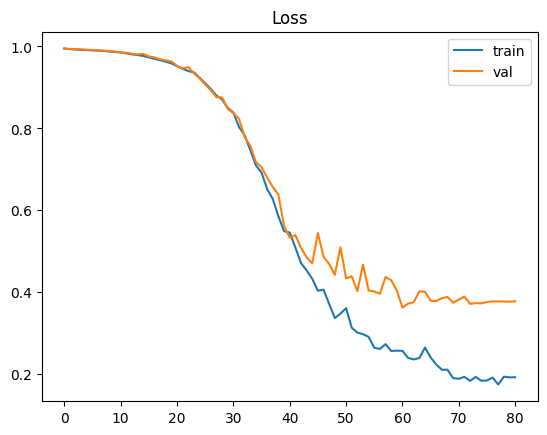

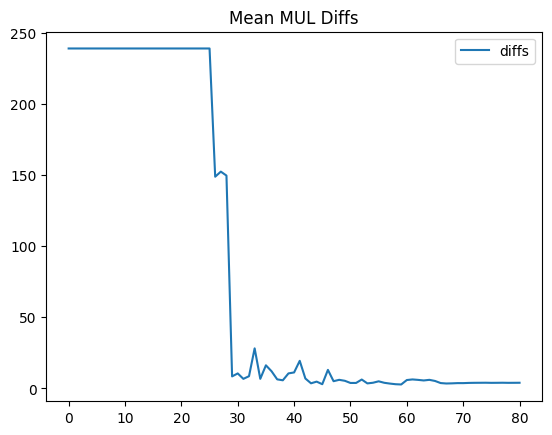

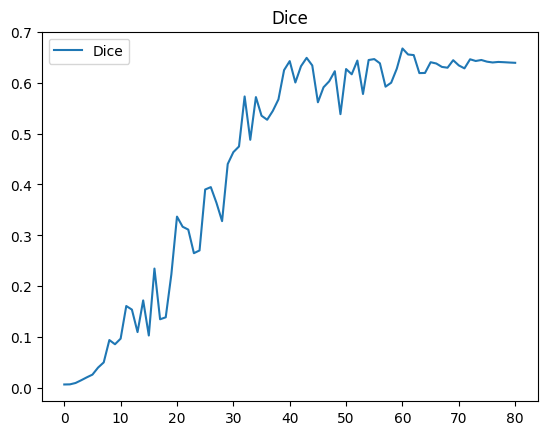

Mean diff: 3.58mm
Std diff: 2.81mm
Mean dice: 0.597

*** FINISHED TRAINING ***


In [17]:
# Params
model_arch = "UNet"
model_backbone = "resnet34"
mask_type = "right_w3"
loss_fn = "dice"
data_aug = True
# l2_reg = 0.000
l2_reg = 0.00
lr = 1e-4
threshold = 0.10
num_epochs = 100
val_size, test_size = 20, 20
# loss_adaptive = False
# loss_alpha = 0.001

batch_size = 4

criterion_bce = nn.BCELoss()
criterion_dice = smp.losses.DiceLoss(mode=smp.losses.BINARY_MODE, log_loss=False, from_logits=False, smooth=1e-6)
# criterion = criterion_dice
# criterion = CombinedLoss(adaptive=loss_adaptive, alpha=loss_alpha)

# ---

def train_model(train_loader, val_loader, num_epochs=100, model_arch="UNet", model_backbone="resnet34", loss_fn="dice", l2_reg=0.000, lr=3e-4, threshold=0.10):
    # Training
    model = get_model(model_arch, model_backbone, DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=0.0001, factor=0.1)
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=20, delta=0.0001, path=f"checkpoint.pt", verbose=False)

    # Keep track of loss and epoch for plotting
    train_losses = []
    val_losses = []
    mean_diffs = []
    mask_losses = []
    length_losses = []

    mask_dice_list = []
    mask_iou_list = []
    mask_acc_list = []

    min_val_loss = np.inf

    results = {"train_losses": [], "val_losses": [], "diffs": [], "mask_losses": [], "length_losses": [], "mask_dice": []}

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0.0
        for batch_idx, batch in enumerate(train_loader):
            images, masks, mul_values = batch
            outputs = model(images)
            
            # pred_masks = (outputs > threshold).float().requires_grad_()
            # pred_lengths = get_length_line_simple(pred_masks).requires_grad_()
            # targets = (targets > 0).float().requires_grad_()
            # target_lengths = get_length_line_simple(targets).requires_grad_()
            
            if loss_fn == "dice":
                loss = criterion_dice(outputs, masks)
            elif loss_fn == "bce":
                loss = criterion_bce(outputs, masks)
            
            # loss = criterion(outputs, pred_lengths, targets, target_lengths, epoch)
            # loss = criterion_bce(outputs, targets)
            # loss = criterion_dice(outputs, targets) + criterion_bce(outputs, targets)
            train_loss += loss.item() * images.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        val_loss = 0.0
        mean_diff = 0.0
        # mask_iou = 0.0
        # mask_accuracy = 0.0
        mask_dice = 0.0
        # mask_loss = 0.0
        # length_loss = 0.0
        
        with torch.no_grad():
            model.eval()
            for batch_idx, batch in enumerate(val_loader):
                images, masks, mul_values = batch
                outputs = model(images)
                
                # first compute statistics for true positives, false positives, false negative and
                # true negative "pixels"
                # tp, fp, fn, tn = smp.metrics.get_stats(outputs, targets.int(), mode="binary", threshold=threshold)

                # then compute metrics with required reduction (see metric docs)
                # iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
                # f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
                # f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
                # accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
                # recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")
                
                # print(iou_score, f1_score, f2_score, accuracy, recall)
                
                pred_masks = (outputs > threshold).float()
                # print(pred_masks.size())
                # print(pred_masks)
                pred_lengths = get_length_line_simple(pred_masks)
                pred_lengths_mm = convert_pixels_to_mm(pred_lengths)

                
                if loss_fn == "dice":
                    loss = criterion_dice(outputs, masks)
                elif loss_fn == "bce":
                    loss = criterion_bce(outputs, masks)
                
                # loss = criterion(outputs, pred_lengths, targets, target_lengths, epoch)
                # loss = criterion_dice(outputs, targets) + criterion_bce(outputs, targets)
                
                val_loss += loss.item() * images.size(0)
                mean_diff += torch.sum(torch.abs(pred_lengths - mul_values))
                
                # print(outputs)
                batch_dice = 0
                for i in range(images.size(0)):
                    dice_score = dice(outputs[i], masks[i].int()).item()
                    batch_dice += dice_score
                    # print(dice_score)
                # print(batch_dice)
                mask_dice += batch_dice
                
                # mask_dice += dice(outputs, targets.int()).item()
                
                # plt.imshow(pred_masks.squeeze(1)[0, :, :].int().detach().cpu().numpy(), cmap="gray")
                # plt.show()
                # plt.imshow(targets.squeeze(1)[0, :, :].int().detach().cpu().numpy(), cmap="gray")
                # plt.show()
                
                # mask_iou += iou_score.item()
                # mask_accuracy += accuracy.item()

                # mask_loss += criterion.mask_loss_fn(pred_masks, targets).item()
                # length_loss += criterion.length_loss_fn(pred_lengths, target_lengths).item()

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        mean_diff /= len(val_loader.dataset)
        mean_diffs.append(mean_diff)
        mask_dice /= len(val_loader.dataset)
        mask_dice_list.append(mask_dice)
        # mask_iou_list.append(mask_iou / len(val_loader.dataset))
        # mask_acc_list.append(mask_accuracy / len(val_loader.dataset))
        # mask_loss /= len(val_loader.dataset)
        # mask_losses.append(mask_loss)
        # length_loss /= len(val_loader.dataset)
        # length_losses.append(length_loss)

        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(val_loss)
        after_lr = optimizer.param_groups[0]["lr"]
        # print("Epoch %d: Adam lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

        # print(f"Epoch {epoch}: train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, diff: {mean_diff}, dice: {mask_dice:.10f}, lr: {optimizer.param_groups[0]["lr"]:.6f}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    
    return model, train_losses, val_losses, mean_diffs, mask_dice_list

def evaluate_model(model, test_loader, threshold):
    images_list = []
    masks_actual_list = []
    masks_pred_list = []
    mul_actual_list = []
    mul_pred_list = []
    diffs_list = []
    dice_list = []
    # gradcam_list = []

    model.eval()
    with torch.no_grad():
        for images, masks, mul_values in test_loader:
            # Forward pass
            outputs = model(images)

            targets_mask = (masks > 0).float()
            preds_mask = (outputs > threshold).float()

            for i in range(images.size(0)):
                dice_score = dice(outputs[i], targets_mask[i].int()).item()
                dice_list.append(dice_score)
                
                targets_mask[i] = thin_line_skeleton(targets_mask[i])
                preds_mask[i] = remove_small_noise(preds_mask[i], kernel_size=10)
                preds_mask[i] = thin_line_skeleton(preds_mask[i])
            
            # tp, fp, fn, tn = smp.metrics.get_stats(outputs, targets.int(), mode="binary", threshold=threshold)

            # then compute metrics with required reduction (see metric docs)
            # iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            # f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            # f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
            # accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

            # Convert tensors to lists or numpy arrays
            images_list.extend(images.squeeze(1).cpu().detach().numpy())
            masks_actual_list.extend(targets_mask.squeeze(1).cpu().detach().numpy())
            masks_pred_list.extend(preds_mask.squeeze(1).cpu().detach().numpy())
            
            # targets_length_mm = get_length_line_simple(targets_mask)
            preds_length_mm = get_length_line_simple(preds_mask)
            
            mul_actual_list.extend(mul_values.cpu().detach().numpy())
            mul_pred_list.extend(preds_length_mm.cpu().detach().numpy())

            diffs = torch.abs(preds_length_mm - mul_values)
            diffs_list.extend(diffs)
    
    return images_list, masks_actual_list, masks_pred_list, mul_actual_list, mul_pred_list, diffs_list, dice_list

def visualize_results(images_list, masks_actual_list, masks_pred_list, mul_actual_list, mul_pred_list, diffs_list, dice_list):
    N_IMAGES = len(images_list)
    fig, axs = plt.subplots(N_IMAGES, 4, figsize=(12, 3 * N_IMAGES))
    
    for i in range(N_IMAGES):
        # mask_actual = (masks_actual_list[i] > 0).float()
        # mask_pred = (masks_pred_list[i] > threshold).float()
        print()
        
        axs[i, 0].imshow(images_list[i], cmap="gray")
        axs[i, 0].set_title(f"Input Image")

        axs[i, 1].imshow(images_list[i], cmap="gray")
        # axs[i, 1].imshow(masks_actual_list[i], cmap=ListedColormap(['none', 'lightcoral']), alpha=1.0)
        axs[i, 1].contour(masks_actual_list[i], colors="lightcoral", linewidths=1.0)
        axs[i, 1].set_title(f"Actual Mask\nMUL: {mul_actual_list[i]:.2f}mm")

        axs[i, 2].imshow(images_list[i], cmap="gray")
        # axs[i, 2].imshow(masks_pred_list[i], cmap=ListedColormap(['none', 'cyan']), alpha=1.0)
        axs[i, 2].contour(masks_pred_list[i], colors="cyan", linewidths=1.0)
        axs[i, 2].set_title(f"Pred Mask\nMUL: {mul_pred_list[i]:.2f}mm")

        # mask_diff = masks_actual_list[i] - masks_pred_list[i]
        # axs[i, 3].imshow(mask_diff, cmap="coolwarm", vmin=-1, vmax=1)
        axs[i, 3].imshow(images_list[i], cmap="gray")
        # axs[i, 3].imshow(masks_actual_list[i], cmap=ListedColormap(['none', 'lightcoral']), alpha=0.7)
        # axs[i, 3].imshow(masks_pred_list[i], cmap=ListedColormap(['none', 'cyan']), alpha=0.7)
        axs[i, 3].contour(masks_actual_list[i], colors='lightcoral', linewidths=1.0, alpha=0.3)
        axs[i, 3].contour(masks_pred_list[i], colors='cyan', linewidths=1.0, alpha=0.3)
        # fig.colorbar(im, ax=axs[i, 3], label='Difference')
        axs[i, 3].set_title(f"Both Masks\nDiff: {diffs_list[i]:.2f}mm / Dice: {dice_list[i]:.2f}")

        # axs[i, j].axis("off")

    for row in axs:
        for ax in row:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred):
    # Calculate plot limits
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    
    # Plot diagonal line
    plt.plot([min_val, max_val], [min_val, max_val], color='red', zorder=1)
    
    # Plot data points
    plt.scatter(y_true, y_pred, zorder=2)
    
    # Set plot title and labels
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual MUL (mm)')
    plt.ylabel('Predicted MUL (mm)')
    
    # Set dynamic y-axis limits
    # plt.xlim(min_val, max_val)
    # plt.ylim(min_val, max_val)
    
    # Add grid lines
    plt.grid(True, linestyle='--', zorder=0)
    
    # Show plot
    plt.show()

def plot_residuals(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    residuals = y_true - y_pred
    plt.scatter(y_true, residuals)
    plt.xlabel('Actual MUL (mm)')
    plt.ylabel('Residuals (Actual - Pred)')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylim(-20, 20)
    plt.show()

results = {}

# pipeline
# for model_arch in ["UNet", "UNet++", "FPN", "DeepLabV3+"]:
#     for model_backbone in ["resnet34", "resnet50", "resnet101"]:
print(f"\n*** TRAINING {model_arch} with {model_backbone} ***")

# Set fixed random number seed
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Dataset
train_loader, val_loader, test_loader = get_data(model_backbone, mask_type, val_size, test_size, batch_size, data_aug)

# Train
model, train_losses, val_losses, mean_diffs, mask_dice_list = train_model(train_loader, val_loader, num_epochs, model_arch, model_backbone, loss_fn, l2_reg, lr, threshold)
plot_model_training_graphs(train_losses, val_losses, mean_diffs, mask_dice_list)

# Load best model
model.load_state_dict(torch.load("checkpoint.pt"))

# Evaluate
images_list, masks_actual_list, masks_pred_list, mul_actual_list, mul_pred_list, diffs_list, dice_list = evaluate_model(model, test_loader, threshold)
print(f"Mean diff: {np.mean(diffs_list):.2f}mm")
print(f"Std diff: {np.std(diffs_list):.2f}mm")
print(f"Mean dice: {np.mean(dice_list):.3f}")
# plot_actual_vs_predicted(mul_actual_list, mul_pred_list)
# plot_residuals(mul_actual_list, mul_pred_list)
# visualize_results(images_list, masks_actual_list, masks_pred_list, mul_actual_list, mul_pred_list, diffs_list, dice_list)

results[(model_arch, model_backbone)] = {
    "mean_diff": np.mean(diffs_list),
    "std_diff": np.std(diffs_list),
    "mean_dice": np.mean(dice_list)
}

print("\n*** FINISHED TRAINING ***")

In [13]:
# Load best model
model.load_state_dict(torch.load("checkpoint.pt"))

<All keys matched successfully>

In [14]:
# import pandas as pd

# # Convert results dictionary to pandas DataFrame
# print(results)
# results_df = pd.DataFrame(results)
# print(results_df.head())

# # Save results to CSV file
# results_csv_filename = f"results_{model_name}_lr{lr:.5f}_a{loss_alpha:.2f}_t{threshold}_e{num_epochs}_m{mask_type}.csv"
# results_df.to_csv(results_csv_filename, index=False)

# print("Results saved to:", results_csv_filename)

### Evaluation

Mean diff: 7.40mm
Std diff: 8.79mm
Mean dice: 0.537


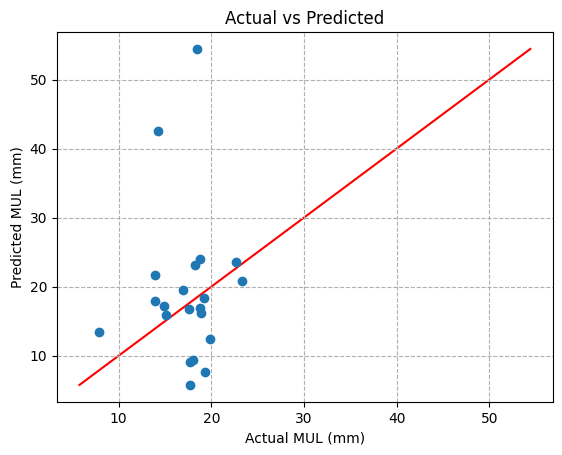

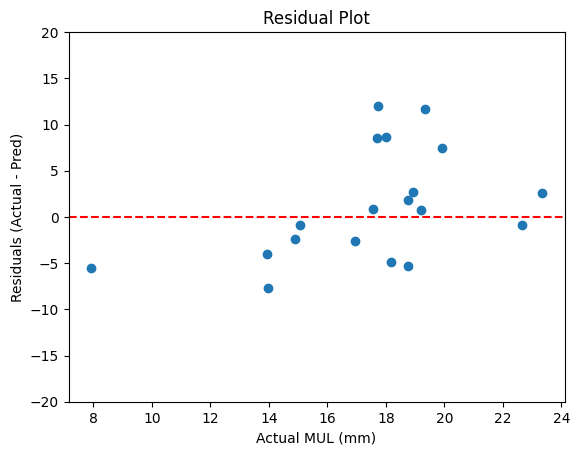

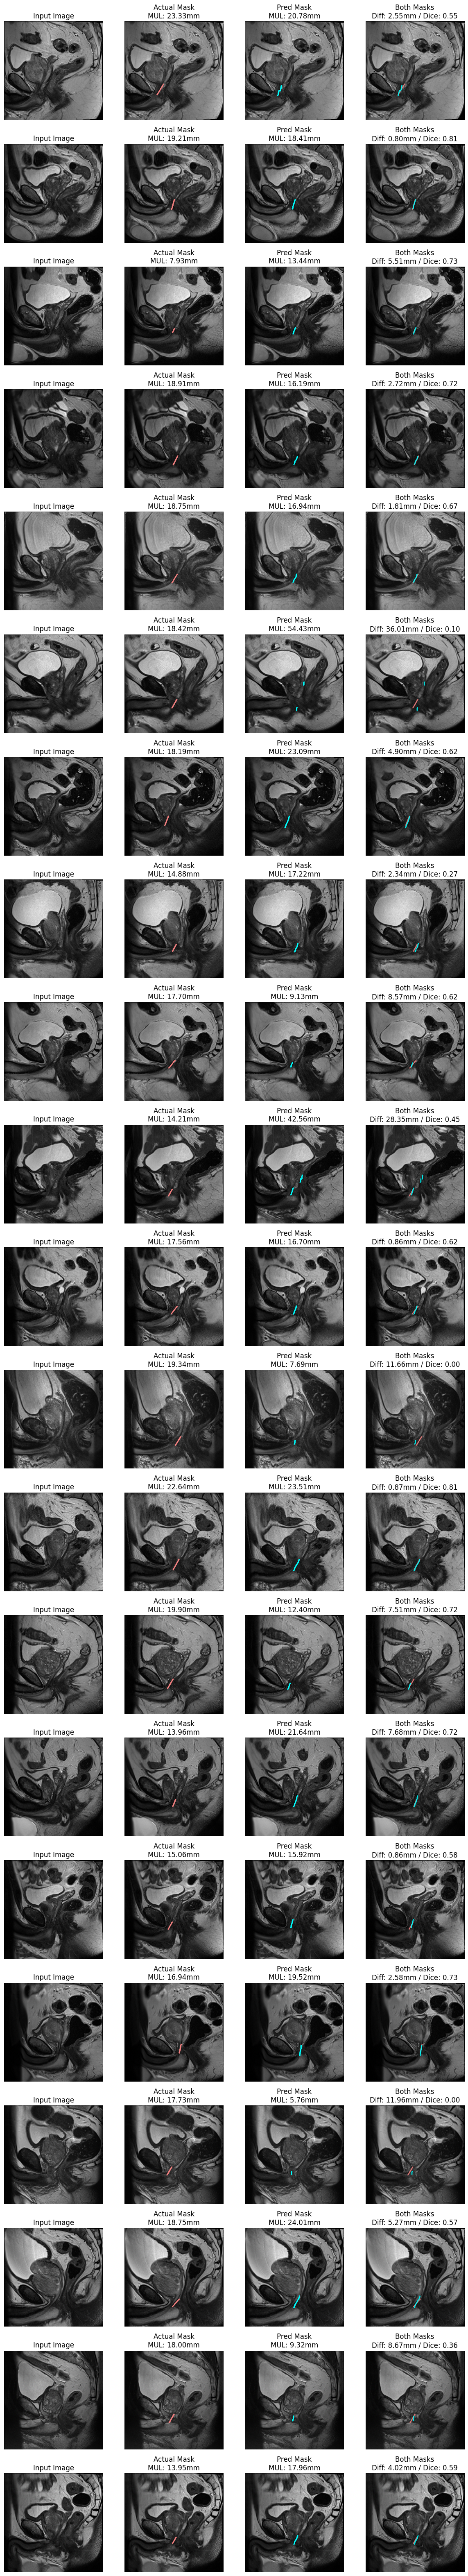

In [15]:
from matplotlib.colors import ListedColormap

def evaluate_model(model, test_loader, threshold):
    images_list = []
    masks_actual_list = []
    masks_pred_list = []
    mul_actual_list = []
    mul_pred_list = []
    diffs_list = []
    dice_list = []
    # gradcam_list = []

    model.eval()
    with torch.no_grad():
        for images, masks, mul_values in test_loader:
            # Forward pass
            outputs = model(images)

            targets_mask = (masks > 0).float()
            preds_mask = (outputs > threshold).float()

            for i in range(images.size(0)):
                dice_score = dice(outputs[i], targets_mask[i].int()).item()
                dice_list.append(dice_score)
                
                targets_mask[i] = thin_line_skeleton(targets_mask[i])
                preds_mask[i] = remove_small_noise(preds_mask[i], kernel_size=10)
                preds_mask[i] = thin_line_skeleton(preds_mask[i])
            
            # tp, fp, fn, tn = smp.metrics.get_stats(outputs, targets.int(), mode="binary", threshold=threshold)

            # then compute metrics with required reduction (see metric docs)
            # iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            # f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
            # f2_score = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro")
            # accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")

            # Convert tensors to lists or numpy arrays
            images_list.extend(images.squeeze(1).cpu().detach().numpy())
            masks_actual_list.extend(targets_mask.squeeze(1).cpu().detach().numpy())
            masks_pred_list.extend(preds_mask.squeeze(1).cpu().detach().numpy())
            
            # targets_length_mm = get_length_line_simple(targets_mask)
            preds_length_mm = get_length_line_simple(preds_mask)
            
            mul_actual_list.extend(mul_values.cpu().detach().numpy())
            mul_pred_list.extend(preds_length_mm.cpu().detach().numpy())

            diffs = torch.abs(preds_length_mm - mul_values)
            diffs_list.extend(diffs)
    
    return images_list, masks_actual_list, masks_pred_list, mul_actual_list, mul_pred_list, diffs_list, dice_list

def visualize_results(images_list, masks_actual_list, masks_pred_list, mul_actual_list, mul_pred_list, diffs_list, dice_list):
    N_IMAGES = len(images_list)
    fig, axs = plt.subplots(N_IMAGES, 4, figsize=(12, 3 * N_IMAGES))
    
    for i in range(N_IMAGES):
        # mask_actual = (masks_actual_list[i] > 0).float()
        # mask_pred = (masks_pred_list[i] > threshold).float()
        print()
        
        axs[i, 0].imshow(images_list[i], cmap="gray")
        axs[i, 0].set_title(f"Input Image")

        axs[i, 1].imshow(images_list[i], cmap="gray")
        # axs[i, 1].imshow(masks_actual_list[i], cmap=ListedColormap(['none', 'lightcoral']), alpha=1.0)
        axs[i, 1].contour(masks_actual_list[i], colors="lightcoral", linewidths=1.0)
        axs[i, 1].set_title(f"Actual Mask\nMUL: {mul_actual_list[i]:.2f}mm")

        axs[i, 2].imshow(images_list[i], cmap="gray")
        # axs[i, 2].imshow(masks_pred_list[i], cmap=ListedColormap(['none', 'cyan']), alpha=1.0)
        axs[i, 2].contour(masks_pred_list[i], colors="cyan", linewidths=1.0)
        axs[i, 2].set_title(f"Pred Mask\nMUL: {mul_pred_list[i]:.2f}mm")

        # mask_diff = masks_actual_list[i] - masks_pred_list[i]
        # axs[i, 3].imshow(mask_diff, cmap="coolwarm", vmin=-1, vmax=1)
        axs[i, 3].imshow(images_list[i], cmap="gray")
        # axs[i, 3].imshow(masks_actual_list[i], cmap=ListedColormap(['none', 'lightcoral']), alpha=0.7)
        # axs[i, 3].imshow(masks_pred_list[i], cmap=ListedColormap(['none', 'cyan']), alpha=0.7)
        axs[i, 3].contour(masks_actual_list[i], colors='lightcoral', linewidths=1.0, alpha=0.3)
        axs[i, 3].contour(masks_pred_list[i], colors='cyan', linewidths=1.0, alpha=0.3)
        # fig.colorbar(im, ax=axs[i, 3], label='Difference')
        axs[i, 3].set_title(f"Both Masks\nDiff: {diffs_list[i]:.2f}mm / Dice: {dice_list[i]:.2f}")

        # axs[i, j].axis("off")

    for row in axs:
        for ax in row:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred):
    # Calculate plot limits
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    
    # Plot diagonal line
    plt.plot([min_val, max_val], [min_val, max_val], color='red', zorder=1)
    
    # Plot data points
    plt.scatter(y_true, y_pred, zorder=2)
    
    # Set plot title and labels
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual MUL (mm)')
    plt.ylabel('Predicted MUL (mm)')
    
    # Set dynamic y-axis limits
    # plt.xlim(min_val, max_val)
    # plt.ylim(min_val, max_val)
    
    # Add grid lines
    plt.grid(True, linestyle='--', zorder=0)
    
    # Show plot
    plt.show()

def plot_residuals(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    residuals = y_true - y_pred
    plt.scatter(y_true, residuals)
    plt.xlabel('Actual MUL (mm)')
    plt.ylabel('Residuals (Actual - Pred)')
    plt.title('Residual Plot')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.ylim(-20, 20)
    plt.show()

threshold = 0.1
eval_loader = test_loader

images_list, masks_actual_list, masks_pred_list, mul_actual_list, mul_pred_list, diffs_list, dice_list = evaluate_model(model, eval_loader, threshold)
print(f"Mean diff: {np.mean(diffs_list):.2f}mm")
print(f"Std diff: {np.std(diffs_list):.2f}mm")
print(f"Mean dice: {np.mean(dice_list):.3f}")

# print(diffs_list)
# print(dice_list)

plot_actual_vs_predicted(mul_actual_list, mul_pred_list)
plot_residuals(mul_actual_list, mul_pred_list)
visualize_results(images_list, masks_actual_list, masks_pred_list, mul_actual_list, mul_pred_list, diffs_list, dice_list)